In [1]:
import os
import shutil
import numpy as np
import glob  
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50                                                                      
from tensorflow.keras.applications.resnet50 import preprocess_input
from matplotlib.pyplot import imshow
%matplotlib inline      

In [2]:
def preprocess_image(image):
    # sharpening kernel
    kernel_sharpening = np.array([[-1,-1,-1],
                                  [-1, 9,-1],
                                  [-1,-1,-1]])

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # median filter for noise reduction
    gray = cv2.medianBlur(gray, 5)

    # Gaussian filter for additional smoothing
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # morphological operations
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # watershed algorithm
    enhanced_image = cv2.filter2D(image, -1, kernel_sharpening)
    markers = cv2.connectedComponents(sure_fg)[1]
    markers = markers + 1
    markers[unknown==255] = 0
    markers = cv2.watershed(enhanced_image, markers)
    enhanced_image[markers == -1] = [0,0,255]

    # resize the image to 224x224
    enhanced_image = cv2.resize(enhanced_image, (224, 224))

    return enhanced_image

# dataset
data_dir = 'C:/code/paddy-disease/training/PlantVillage'

# Training data dir
training_dir = 'C:/code/paddy-disease/training/Train'

# Test data dir
testing_dir = 'C:/code/paddy-disease/training/Test'

# Ratio of training and testing data
train_test_ratio = 0.9

def split_dataset_into_test_and_train_sets(all_data_dir=data_dir, training_data_dir=training_dir, 
                                           testing_data_dir=testing_dir, train_test_ratio=0.9):
    # Recreate testing and training directories
    if not os.path.exists(training_data_dir):
        os.mkdir(training_data_dir)

    if not os.path.exists(testing_data_dir):
        os.mkdir(testing_data_dir)               
    
    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)
        if category_name == os.path.basename(all_data_dir):
            continue
    
        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name
        
        # creating subdir for each sub category
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)   

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
            
        file_list = glob.glob(os.path.join(subdir,'*.jpg'))
        print(str(category_name) + ' has ' + str(len(files)) + ' images') 
        random_set = np.random.permutation((file_list))
        # copy percentage of data from each category to train and test directory
        train_list = random_set[:round(len(random_set)*(train_test_ratio))] 
        test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]

        for lists in train_list : 
            img = cv2.imread(lists)
            if img is not None:
                img_preprocessed = preprocess_image(img)
                cv2.imwrite(training_data_dir + '/' + category_name + '/' + os.path.basename(lists), img_preprocessed)
                num_training_files += 1
  
        for lists in test_list : 
            img = cv2.imread(lists)
            if img is not None:
                img_preprocessed = preprocess_image(img)
                cv2.imwrite(testing_data_dir + '/' + category_name + '/' + os.path.basename(lists), img_preprocessed)
                num_testing_files += 1
  

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [3]:
split_dataset_into_test_and_train_sets()

bacterial_leaf_blight has 438 images
brown_spot has 466 images
healthy has 464 images
leaf_blast has 454 images
leaf_scald has 448 images
narrow_brown_spot has 440 images
Processed 2439 training files.
Processed 271 testing files.


In [6]:
from tensorflow.keras.regularizers import l1_l2
num_classes = 6

def get_model():
    # Define the Keras model with dynamic input shape
    input_shape = (None, None, 3)  # Dynamic shape
    inputs = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    for layer in base_model.layers:
        layer.trainable = False
    base_model_output = base_model.output

    # Adding our own layer 
    x = GlobalAveragePooling2D()(base_model_output)
    # Adding fully connected layer with L2 regularization
    x = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
    # Adding dropout regularization
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax', name='fcnew')(x)

    # Define the Keras model with dynamic output shape
    model = Model(inputs=inputs, outputs=x)
    return model


In [7]:
# Get the model
model = get_model()
# Compile it

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
# Summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [8]:
# Number of classes in dataset
num_classes = 6
image_size=224
batch_size= 32
# Get the model
model = get_model()

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall() ])

train_data_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_data_gen.flow_from_directory(training_dir,
                                                     target_size=(image_size, image_size),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

valid_generator = valid_data_gen.flow_from_directory(testing_dir,
                                                     target_size=(image_size, image_size),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.callbacks as callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.2 ** epoch)

# Train the model
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=valid_generator,
                    callbacks=[early_stopping, reduce_lr, lr_schedule],
                    class_weight=class_weights)


Found 2710 images belonging to 6 classes.
Found 1681 images belonging to 6 classes.
Epoch 1/30
85/85 [==============================] - 778s 9s/step - loss: 64.8457 - accuracy: 0.6413 - precision: 0.7367 - recall: 0.5266 - val_loss: 4.9814 - val_accuracy: 0.6901 - val_precision: 0.8000 - val_recall: 0.5211 - lr: 0.0010
Epoch 2/30
85/85 [==============================] - 738s 9s/step - loss: 2.7770 - accuracy: 0.7277 - precision: 0.8546 - recall: 0.5096 - val_loss: 2.2085 - val_accuracy: 0.7573 - val_precision: 0.9158 - val_recall: 0.5175 - lr: 2.0000e-04
Epoch 3/30
85/85 [==============================] - 736s 9s/step - loss: 1.9028 - accuracy: 0.7295 - precision: 0.8687 - recall: 0.4930 - val_loss: 1.8305 - val_accuracy: 0.7472 - val_precision: 0.8913 - val_recall: 0.4973 - lr: 4.0000e-05
Epoch 4/30
85/85 [==============================] - 739s 9s/step - loss: 1.7627 - accuracy: 0.7339 - precision: 0.8722 - recall: 0.4834 - val_loss: 1.7464 - val_accuracy: 0.7519 - val_precision: 0.89

In [9]:
# Unfreeze some layers in the pre-trained model
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model with fine-tuning
history = model.fit(train_generator,
                    epochs=50,                   validation_data=valid_generator,
                    callbacks=[early_stopping, reduce_lr, lr_schedule],
                    class_weight=class_weights)


Epoch 1/50
85/85 [==============================] - 1362s 16s/step - loss: 3.7111 - accuracy: 0.7384 - precision_1: 0.8512 - recall_1: 0.5867 - val_loss: 3.0137 - val_accuracy: 0.7841 - val_precision_1: 0.8097 - val_recall_1: 0.7543 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 1359s 16s/step - loss: 1.1746 - accuracy: 0.8930 - precision_1: 0.9295 - recall_1: 0.8269 - val_loss: 0.8578 - val_accuracy: 0.9221 - val_precision_1: 0.9384 - val_recall_1: 0.8977 - lr: 2.0000e-04
Epoch 3/50
85/85 [==============================] - 1353s 16s/step - loss: 0.6560 - accuracy: 0.9155 - precision_1: 0.9412 - recall_1: 0.8738 - val_loss: 0.5459 - val_accuracy: 0.9209 - val_precision_1: 0.9411 - val_recall_1: 0.9036 - lr: 4.0000e-05
Epoch 4/50
85/85 [==============================] - 1551s 18s/step - loss: 0.5615 - accuracy: 0.9199 - precision_1: 0.9461 - recall_1: 0.8738 - val_loss: 0.4717 - val_accuracy: 0.9280 - val_precision_1: 0.9454 - val_recall_1: 0.9060 - lr: 8.0000e-06
Epoc

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Get the test data
test_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = test_data_gen.flow_from_directory(testing_dir,
                                                   target_size=(image_size, image_size),
                                                   batch_size=batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical')

# Make predictions on the test data
y_pred = model.predict(test_generator)

# Get the predicted labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels
y_true_labels = test_generator.classes

# Print the classification report and confusion matrix
print('Classification Report:')
print(classification_report(y_true_labels, y_pred_labels))
print('Confusion Matrix:')
print(confusion_matrix(y_true_labels, y_pred_labels))


Found 1681 images belonging to 6 classes.
53/53 [==============================] - 300s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       277
           1       0.91      0.84      0.88       296
           2       0.84      0.99      0.91       301
           3       0.95      0.76      0.85       272
           4       0.99      0.99      0.99       279
           5       0.91      1.00      0.95       256

    accuracy                           0.93      1681
   macro avg       0.93      0.93      0.93      1681
weighted avg       0.93      0.93      0.93      1681

Confusion Matrix:
[[274   0   0   0   2   1]
 [  1 250  16  10   0  19]
 [  0   2 298   1   0   0]
 [  0  21  42 208   1   0]
 [  0   0   0   0 275   4]
 [  0   1   0   0   0 255]]


In [11]:
history

In [12]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 85}

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'lr'])

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

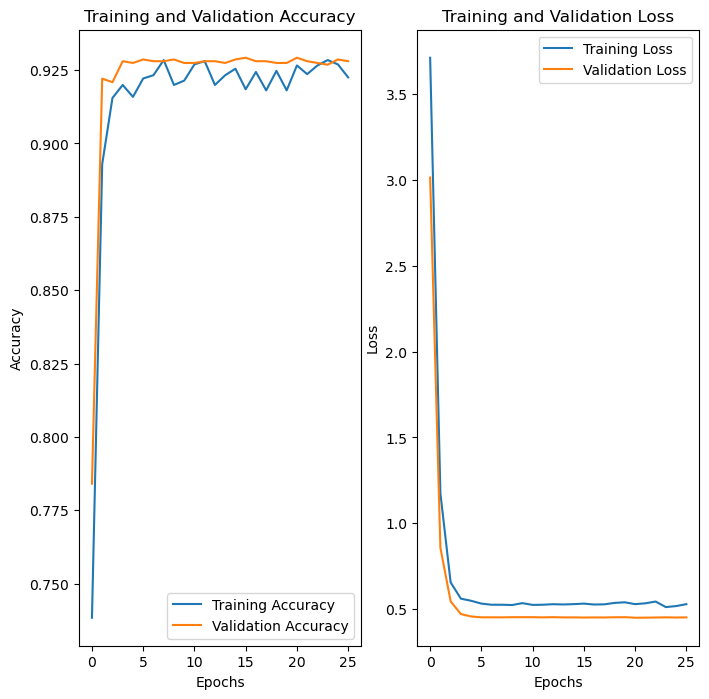

In [15]:
import matplotlib.pyplot as plt

epochs=26

# Create figure and subplots
fig, ax = plt.subplots(figsize=(8, 8), nrows=1, ncols=2)

# Plot Training and Validation Accuracy
ax[0].plot(range(epochs), acc, label='Training Accuracy')
ax[0].plot(range(epochs), val_acc, label='Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training and Validation Accuracy')

# Plot Training and Validation Loss
ax[1].plot(range(epochs), loss, label='Training Loss')
ax[1].plot(range(epochs), val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training and Validation Loss')

# Display the plot
plt.show()

In [16]:
class_names = ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']

In [17]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 234ms/step


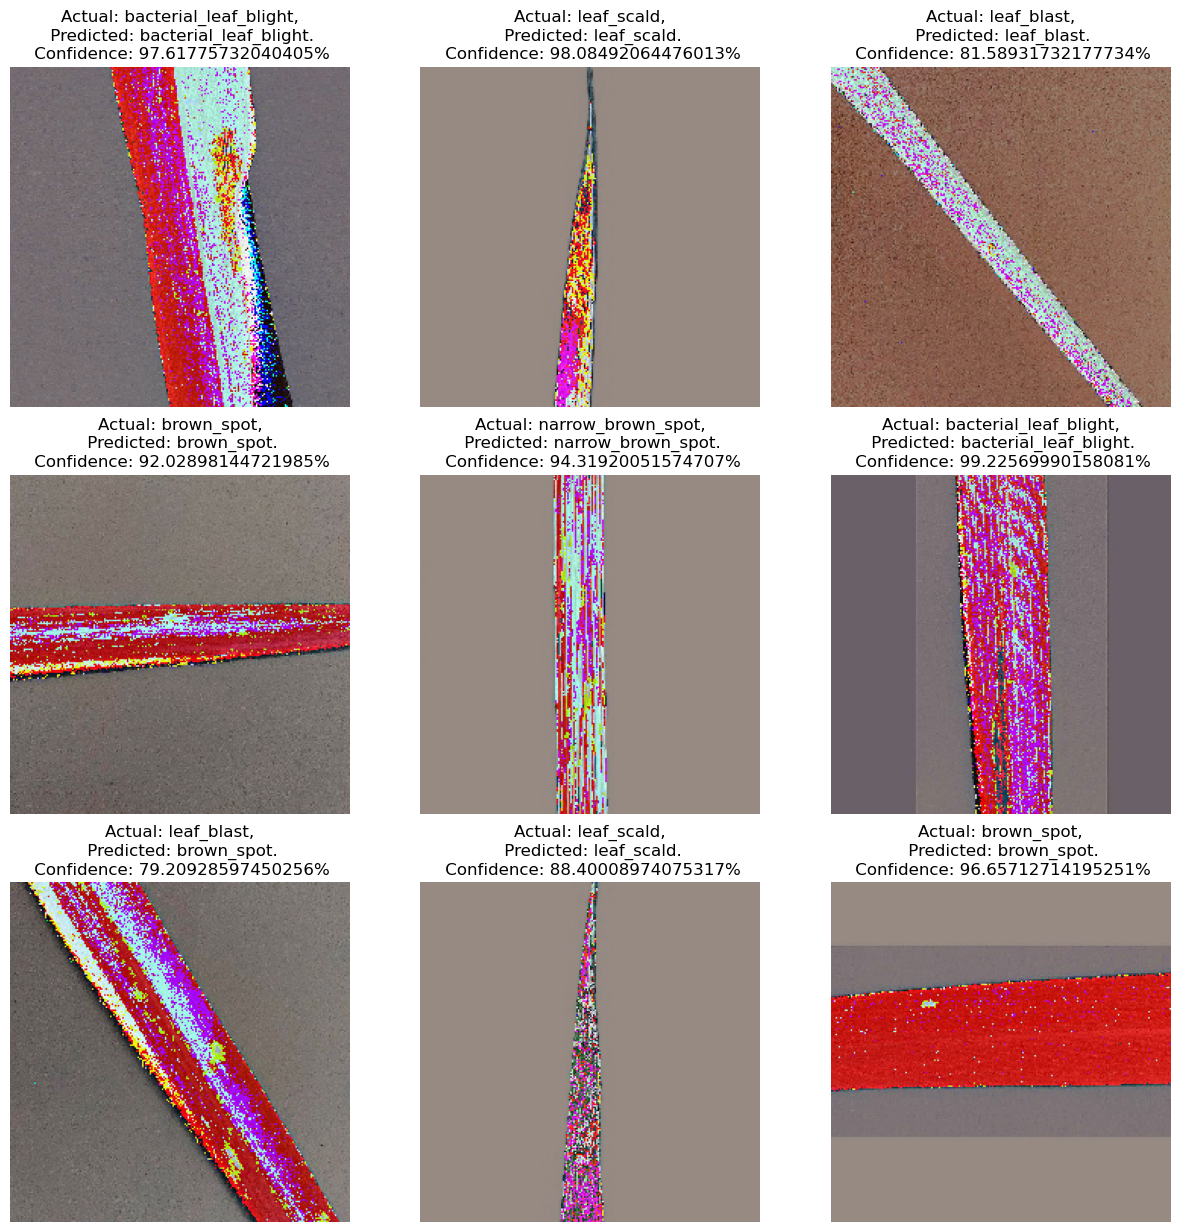

In [18]:
plt.figure(figsize=(15, 15))
images, labels = next(valid_generator)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))

    predicted_class_probs = model.predict(np.expand_dims(images[i], axis=0))[0]
    predicted_class = class_names[np.argmax(predicted_class_probs)]
    confidence = predicted_class_probs[np.argmax(predicted_class_probs)] * 100
    actual_class = class_names[np.argmax(labels[i])]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")


In [19]:
import os
import tensorflow as tf
from tensorflow import keras

model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1

model = keras.models.load_model("../saved_models/<model_version>")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("../saved_models/<model_version>.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets


In [20]:
model.save("../paddys.h5")

In [23]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('../paddys.h5')

# Convert the model to TFLite format with post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('paddyoptimizetf.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpb7322axk\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpb7322axk\assets


In [21]:
import numpy as np
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="paddyoptimizetf.tflite")
interpreter.allocate_tensors()

interpreter.allocate_tensors()
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get input shape and type
input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']
print("Input shape: ", input_shape)
print("Input type: ", input_dtype)

# Get output shape and type
output_shape = output_details[0]['shape']
output_dtype = output_details[0]['dtype']
print("Output shape: ", output_shape)
print("Output type: ", output_dtype)

Input shape:  [1 1 1 3]
Input type:  <class 'numpy.float32'>
Output shape:  [1 6]
Output type:  <class 'numpy.float32'>


In [22]:
interpreter.resize_tensor_input(input_details[0]['index'], (1, 224, 224, 3))
interpreter.allocate_tensors()
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get input shape and type
input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']
print("Input shape: ", input_shape)
print("Input type: ", input_dtype)

# Get output shape and type
output_shape = output_details[0]['shape']
output_dtype = output_details[0]['dtype']
print("Output shape: ", output_shape)
print("Output type: ", output_dtype)

Input shape:  [  1 224 224   3]
Input type:  <class 'numpy.float32'>
Output shape:  [1 6]
Output type:  <class 'numpy.float32'>


In [23]:
input_tensor = tf.keras.layers.Input(shape=(None, None, 3))
resized_input_tensor = tf.image.resize(input_tensor, (224, 224))

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.inference_input_type = tf.float32

converter.inference_output_type = tf.float32

converter.inference_input_shape = (1, 224, 224, 3)

tflite_model = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpva15q5dx\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpva15q5dx\assets


In [26]:
with tf.io.gfile.GFile('paddy_optimizetflite.tflite', 'wb') as f:
    f.write(tflite_model)

In [1]:
import tensorflow as tf

# Load the saved Keras model
model = tf.keras.models.load_model("../paddy.h5")

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("paddy_tflite.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmp51e2e3vm\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmp51e2e3vm\assets


In [2]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="paddy_tflite.tflite")
interpreter.allocate_tensors()

interpreter.allocate_tensors()
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get input shape and type
input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']
print("Input shape: ", input_shape)
print("Input type: ", input_dtype)

# Get output shape and type
output_shape = output_details[0]['shape']
output_dtype = output_details[0]['dtype']
print("Output shape: ", output_shape)
print("Output type: ", output_dtype)

Input shape:  [1 1 1 3]
Input type:  <class 'numpy.float32'>
Output shape:  [1 6]
Output type:  <class 'numpy.float32'>


In [24]:
import numpy as np
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="paddyoptimizetf.tflite")

# Define the new input and output shapes/types
new_input_shape = [1, 224, 224, 3] # [batch_size, height, width, channels]
new_input_type = tf.float32
new_output_shape = [1, 6] # [batch_size, num_classes]
new_output_type = tf.float32

# Set the new input and output shapes/types for the interpreter
interpreter.resize_tensor_input(0, new_input_shape)
interpreter.resize_tensor_input(1, new_output_shape)
interpreter.resize_tensor_input(2, new_output_shape)
interpreter.allocate_tensors()
interpreter.set_tensor(0, np.zeros(new_input_shape, dtype=new_input_type))
interpreter.set_tensor(1, np.zeros(new_output_shape, dtype=new_output_type))
interpreter.set_tensor(2, np.zeros(new_output_shape, dtype=new_output_type))
interpreter.invoke()

# Get the input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print the new input and output shapes/types
print("New input shape:", input_details[0]['shape'])
print("New input type:", input_details[0]['dtype'])
print("New output shape:", output_details[0]['shape'])
print("New output type:", output_details[0]['dtype'])


RuntimeError: Attempting to resize a fixed-size tensor.

In [25]:
import numpy as np
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="paddyoptimizetf.tflite")

# Define the new input shape/type
new_input_shape = [1, 224, 224, 3] # [batch_size, height, width, channels]
new_input_type = tf.float32

# Get the input details
input_details = interpreter.get_input_details()

# Modify the input details with the new shape and type
interpreter.resize_tensor_input(input_details[0]['index'], new_input_shape)
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], np.zeros(new_input_shape, dtype=new_input_type))
interpreter.invoke()

# Print the new input shape/type
print("New input shape:", interpreter.get_input_details()[0]['shape'])
print("New input type:", interpreter.get_input_details()[0]['dtype'])


TypeError: Cannot interpret 'tf.float32' as a data type

In [27]:
import tensorflow as tf
import numpy as np

# Define and train your Keras model with the desired input and output shapes

# Convert the Keras model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model('../paddys.h5')

# Set the desired input and output shapes
input_shape = [1, 224, 224, 3]
output_shape = [1, 6]
converter.representative_dataset = lambda: iter([np.zeros(input_shape)])
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
converter.inference_input_tensor(input_shape)
converter.inference_output_tensor(output_shape)

# Convert the TFLite model and save it to a file
tflite_model = converter.convert()
with open('custom_tflite_model.tflite', 'wb') as f:
    f.write(tflite_model)


AttributeError: 'TFLiteKerasModelConverterV2' object has no attribute 'inference_input_tensor'

In [44]:
import tensorflow as tf
import numpy as np

# Define and train your Keras model with the desired input and output shapes

model = tf.keras.models.load_model('../paddy.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)


# Set the desired input and output shapes
input_shape = [1, 224, 224, 3]
output_shape = [1, 6]

# Set the input and output details using optimizations argument
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
converter.experimental_new_converter = True
converter.experimental_new_quantizer = True
converter._experimental_lower_tensor_list_ops = False  # Required for TensorFlow 2.6.0 or later
converter.allow_custom_ops = True  # Required for custom input and output shapes
converter.input_spec = [tf.TensorSpec(shape=input_shape, dtype=tf.float32, name='input_1')]
converter.output_spec = [tf.TensorSpec(shape=output_shape, dtype=tf.float32, name='dense_2')]

# Convert the TFLite model and save it to a file
tflite_model = converter.convert()
with open('custom_tflite_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpdhp3o46i\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpdhp3o46i\assets


In [33]:
print(type(converter._keras_model))


<class 'str'>


In [46]:
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='custom_tflite_model.tflite')

# Print the input tensor shape
input_details = interpreter.get_input_details()
print('Input shape:', input_details[0]['shape'])

# Print the output tensor shape
output_details = interpreter.get_output_details()
print('Output shape:', output_details[0]['shape'])


Input shape: [1 1 1 3]
Output shape: [1 6]


In [47]:
import tensorflow as tf
import numpy as np

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="custom_tflite_model.tflite")
interpreter.allocate_tensors()

# Get the input tensor shape
input_details = interpreter.get_input_details()[0]
print(input_details['shape'])  # Should print [1, 224, 224, 3]

# Create some sample input data
input_data = np.random.rand(*input_details['shape']).astype(np.float32)

# Perform inference on the input data
interpreter.set_tensor(input_details['index'], input_data)
interpreter.invoke()

# Get the output tensor
output_details = interpreter.get_output_details()[0]
output_data = interpreter.get_tensor(output_details['index'])
print(output_data)  # Should print the output tensor data


[1 1 1 3]
[[5.4136521e-01 9.8383427e-03 3.3102974e-02 4.0785229e-01 4.4703105e-04
  7.3941732e-03]]


In [41]:
import os
import tensorflow as tf
from tensorflow import keras

model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1

model = keras.models.load_model("../saved_models/2")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("custom_tflite_model.tflite.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpb40gyqaq\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpb40gyqaq\assets


In [45]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="custom_tflite_model.tflite.tflite")
interpreter.allocate_tensors()

interpreter.allocate_tensors()
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get input shape and type
input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']
print("Input shape: ", input_shape)
print("Input type: ", input_dtype)

# Get output shape and type
output_shape = output_details[0]['shape']
output_dtype = output_details[0]['dtype']
print("Output shape: ", output_shape)
print("Output type: ", output_dtype)

Input shape:  [1 1 1 3]
Input type:  <class 'numpy.float32'>
Output shape:  [1 6]
Output type:  <class 'numpy.float32'>
